# Application: Galaxy Classification

Galaxies come in [many different shapes](https://en.wikipedia.org/wiki/Galaxy_morphological_classification).  Large surveys can images 100,000s or millions of galaxies, and we want to be able to classify them into types.  We can use a neural network for this.

We will use the [Galaxy10 DECaLS dataset](https://astronn.readthedocs.io/en/latest/galaxy10.html) [(Leung & Bovy 2024)](https://zenodo.org/records/10845026),
which contains 17736 images of galaxies, each 256x256 pixels and 3 colors (g, r, and z bands), classified into 10 different categories.  It also provides RA and dec, redshift, and pixel scale---we'll ignore those.

```{tip}
We can create additional training data from this set via transformations: rotating it, flipping it, etc.
That can help with the training.  Since the orientation of the galaxies do not matter, this should not
be a problem.
```

You can get the dataset from Zenodo: [Galaxy10_DECals.h5](https://zenodo.org/records/10845026/files/Galaxy10_DECals.h5)

This is an [HDF5](https://www.hdfgroup.org/solutions/hdf5/) file---this is a self-describing binary format that is popular in scientific computing.  We can read it in python using the
[h5py library](https://www.h5py.org/).

```{warning}
This is a big dataset (~2.5 GB), so we need to be careful with memory.
```

```{note}
There is not a separate training and test set, so we will partition this dataset ourselves.
```

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

If we look at the dataset, we can see the fields:

In [3]:
ds = h5py.File("Galaxy10_DECals.h5")
ds.keys()

<KeysViewHDF5 ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']>

let's look at the answers

In [4]:
ans = np.array(ds["ans"])
ans.shape, ans.dtype

((17736,), dtype('uint8'))

We see that there are 17736 records, stored as a NumPy array.

```{important}
The galaxies are stored in the dataset sorted by type.  So all of the "disturbed galaxies" (type `0`) come first, then the "merging galaxies", ...
```

## Exploring the data

Let's define descriptive names for the galaxy types

In [5]:
galaxy_types = {0: "disturbed galaxies",
                1: "merging galaxies",
                2: "round smooth galaxies",
                3: "in-between round smooth galaxies",
                4: "cigar shaped smooth galaxies",
                5: "barred spiral galaxies",
                6: "unbarred tight spiral galaxies",
                7: "unbarred loose spiral galaxies",
                8: "edge-on galaxies without bulge",
                9: "edge-on galaxies with bulge"}

We'll also create a simple class (`Galaxy`) to manage the data.

Here we pass in the image data for a single galaxy as a NumPy `uint8` array---the same datatype used in the file.  This class will convert it to a single precision floating-point array, scaled to fall between 0 and 1.  We also convert the answer to a categorical datatype (and array of length 10).

In [6]:
class Galaxy:
    def __init__(self, data, answer, *, index=-1):
        self.data = np.array(data, dtype=np.float32) / 255.0 * 0.99 + 0.01
        self.answer = answer

        self.out = np.zeros(10, dtype=np.float32) + 0.01
        self.out[self.answer] = 0.99

        self.index = index

    def plot(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.imshow(self.data, interpolation="nearest")
        ax.text(0.025, 0.95, f"answer: {self.answer}",
                color="white", transform=ax.transAxes)

    def validate(self, prediction):
        """check if a categorical prediction matches the answer"""
        return np.argmax(prediction) == self.answer

Now let's find the first example of each type and plot it

In [7]:
images = ds["images"]
images.dtype

dtype('uint8')

```{note}
This doesn't read in the data.  It just provides a `Dataset` type that can be used
to access the data, so we can get a single galaxy at a time.
```

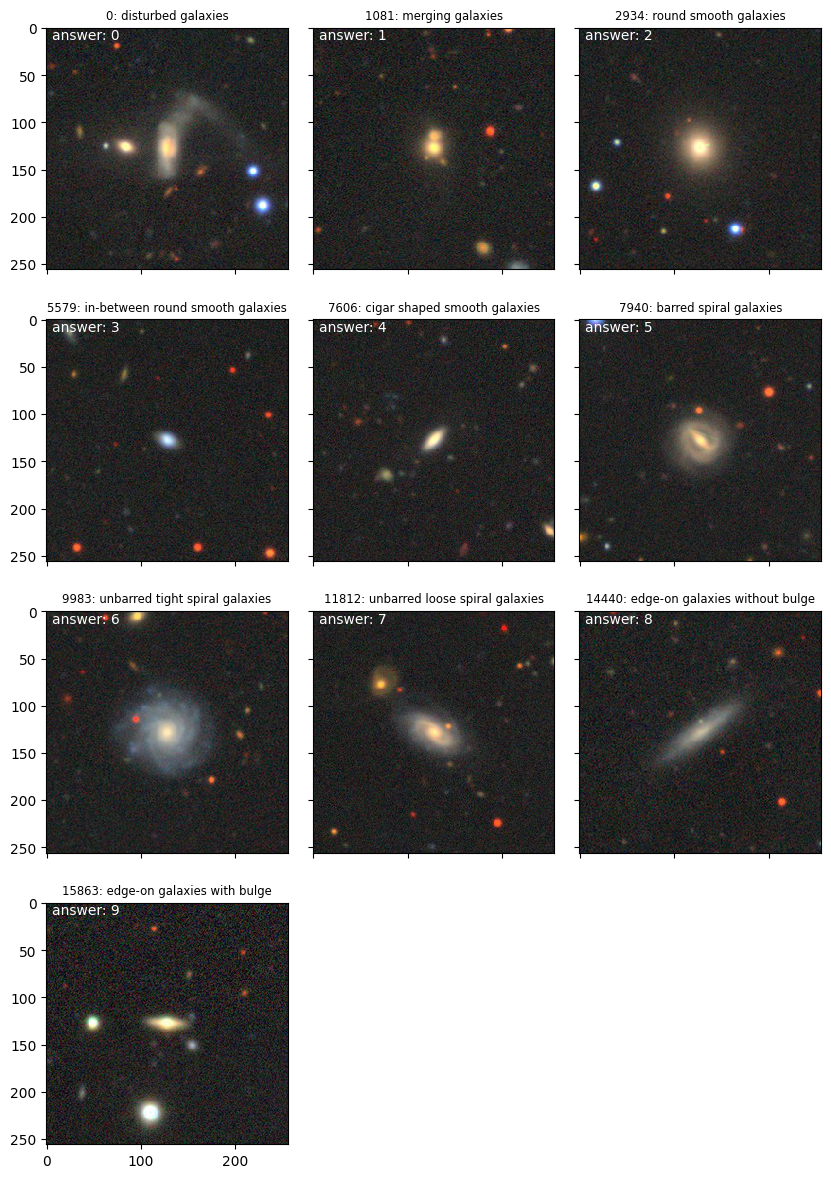

In [8]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure()
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 3),
                 axes_pad=(0.25, 0.5))

for i in range(10):
    idx = np.where(ans == i)[0][0]
    g = Galaxy(images[idx, :, :, :], ans[idx])
    g.plot(ax=grid[i])
    grid[i].set_title(f"{idx}: {galaxy_types[i]}", fontsize="small")

grid[10].set_axis_off()
grid[11].set_axis_off()
fig.set_size_inches(10, 15)

```{important}
Since each class of galaxy is stored together in the file, we will want to
randomize the order before splitting into training and testing sets.
```

## Convolution layers

A [convolution neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) takes a small group of pixels in the image (like $3\times 3$) and apply a kernel (or many kernels) to the data and connect it to the next layer.  As a result, instead of every pixel on the input layer being connected to every neuron on the next layer, many fewer connections are created.

We won't write this from scratch, but instead we will use Keras to implement it.  Typically, a few convolution layers are stacked, with each using many kernels, and then a reduction or pooling is done, reducing the size of the data.  Many such groups of convolution + pooling may be connected together before finally doing a dense connection to the output layer.